In [73]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from collections import Counter

# Import user defined functions.
import parse as prs

# Read and parse json.
df = pd.read_json('data/train.json')

# Defining names of the target
target_names = ['high','medium','low']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# A quick look at the dataframe.
rows = np.random.choice(df.index.values, 3)
sampled_df = df.ix[rows]
sampled_df

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
21478,1.0,1,880b1f1686459ebdae4a154ae5b75f66,2016-06-24 08:27:10,"Located in the heart of Lincoln Square, the bu...",W 66th St.,"[Dining Room, Doorman, Elevator, Fitness Cente...",low,40.7733,7211786,-73.9814,5599e962719af3ccc2976855c2d5893c,[https://photos.renthop.com/2/7211786_b520369c...,5250,60 W 66th St.
86071,1.0,3,f1833846e5f958df2a97e2b0258820e0,2016-04-20 03:42:32,LAUNDRY IN UNIT<br /><br />Bond New York is a ...,Amsterdam Avenue,[],low,40.8012,6899984,-73.9647,6258f603d2df9463fd6de58f75f20cbb,[https://photos.renthop.com/2/6899984_e1019b83...,3850,965 Amsterdam Avenue
31794,1.0,1,61069a7cb537d02dd8ca82a6ccff819c,2016-06-10 02:30:57,The story luxury rental apartment building is...,Sixth Avenue,"[Doorman, Elevator, Terrace, Outdoor Space, Do...",low,40.7452,7134371,-73.9916,5c50a37609dd7e7863d1afee5da184a6,[https://photos.renthop.com/2/7134371_a3bd0399...,4520,777 Sixth Avenue


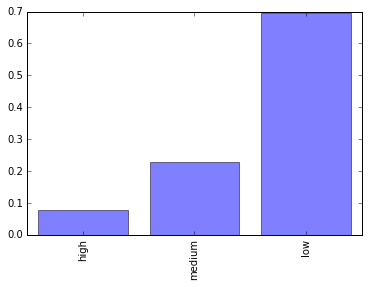

In [5]:
# Proportion of interest level.
prop_interest = []
for interest_name in target_names:
   prop_interest.append(np.float(np.sum(df.interest_level==interest_name))/np.float(np.shape(df)[0]))

# Plotting as graph bar.
y_pos = np.arange(len(target_names))
plt.bar(y_pos, prop_interest, align='center', alpha=0.5)
plt.xticks(y_pos, target_names, rotation='vertical') 
plt.show()

In [83]:
# Looking at features
rows = np.random.choice(df.index.values, 5000)
sampled_features = df["features"].ix[rows]
#print(sampled_features)
#print(sampled_features.iloc[[0]].values)

allFeatures=[]
for row in rows:
    allFeatures.extend(sampled_features.loc[[row]].values[0])

from collections import Counter
words_to_count = (word for word in allFeatures if word[:1].isupper())
c = Counter(words_to_count)
print c.most_common(3)

#To-do, add n most common features as dummies variables

[(u'Elevator', 2649), (u'Cats Allowed', 2449), (u'Hardwood Floors', 2351)]


In [54]:
X, y = prs.parse_1(df.copy()),prs.target(df)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [ ]:
clf = RandomForestClassifier(n_estimators=1000)
clf = clf.fit(X_train, y_train)

In [ ]:
y_val_pred = clf.predict_proba(X_val)
val_loss = log_loss(y_val,y_val_pred)
print(val_loss)
y_train_pred = clf.predict_proba(X_train)
train_loss = log_loss(y_train,y_train_pred)
print(train_loss)

In [ ]:
# Predicting data.
df_test = pd.read_json('data/test.json')
X_test = prs.parse_1(df_test.copy())
y_test_pred = clf.predict_proba(X_test)
ids = df_test['listing_id'].values


In [ ]:
# Writting the submission file
labels2idx = {label: i for i, label in enumerate(clf.classes_)}
labels2idx
subm = pd.DataFrame()
subm["listing_id"] = df_test["listing_id"]
for label in ["high", "medium", "low"]:
    subm[label] = y_test_pred[:, labels2idx[label]]
subm.to_csv("submission.csv", index=False)